# Make bar plots of ROH tracts
Make admixture style plots of ROH, both expected as well as for empirical Individuals

In [3]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
elif socket_name.startswith("Harald-Laptop"):
    print("Harald laptop detected.")
    path = "/home/hringbauer/git/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.append("./package") # Append Hapsburg Folder
from hapsburg.PackagesSupport.roh_expectations import Expected_Roh
from hapsburg.figures.plot_bars import plot_panel_row, plot_legend_only, \
                                prepare_dfs_plot, prep_dfs_plot_exact  # See the cunctions at the bottom ("legacy")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Single Example for theoretical Expectations [For Supplement]

Saved figure to ./figures/manuscript/barplots/bar_legend.pdf


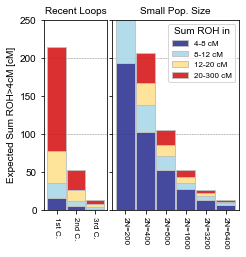

In [4]:
plot_legend_only(savepath="./figures/manuscript/barplots/bar_legend.pdf", 
                 figsize=(3.5,3.5), ylim=[0, 250],
                 c=["#313695", "#abd9e9", "#fee090", "#d7191c"],
                 degrees=[1, 2, 3], hlines=[100, 200, 300, 400], fs_l=8,
                 Ns=[200, 400, 800, 1600, 3200, 6400])

## Do the Plot for empirical data

### Roman Data Row

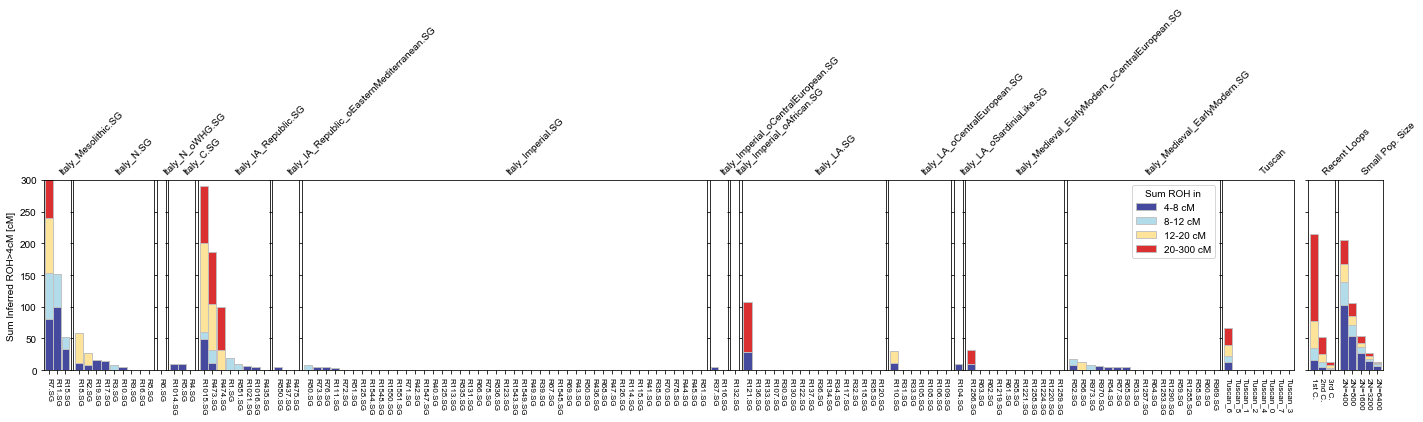

In [2]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1[df1["region"]=="Rome"]
plot_dfs, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])

plot_panel_row(plot_dfs, savepath="",  #./figures/roman_pilot.png
               wspace=0.035, r_title=45, leg_pos=-2, ylim=[0,300])

## Iberia transect Row

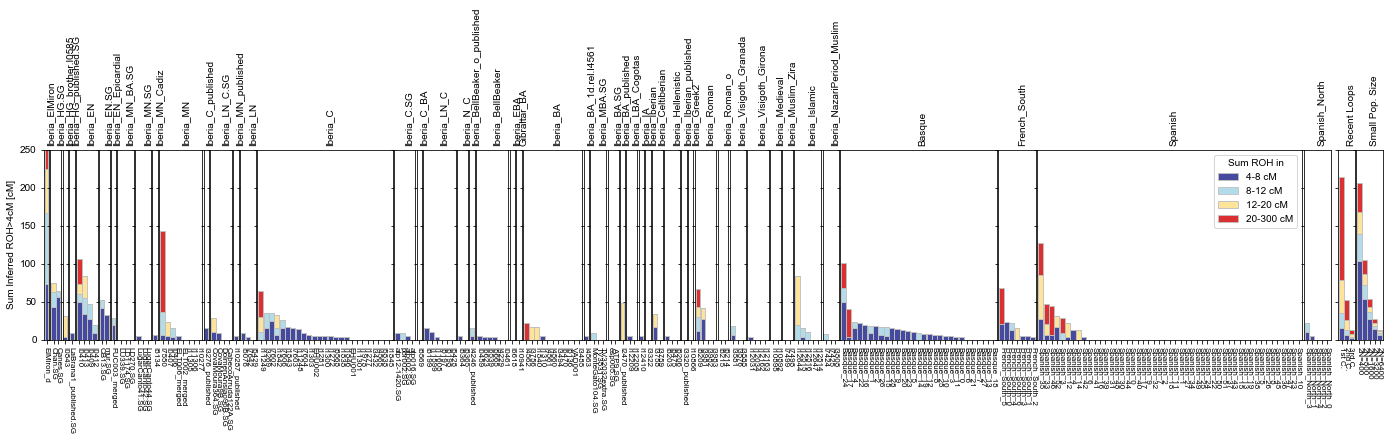

In [5]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1[df1["region"]=="Iberia"]
#df1["clst"]=df1["pop"]
plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])
plot_panel_row(plot_dfs1, savepath="", leg_pos=-2) # ./figures/iberia_pilot.pdf

### Aegan

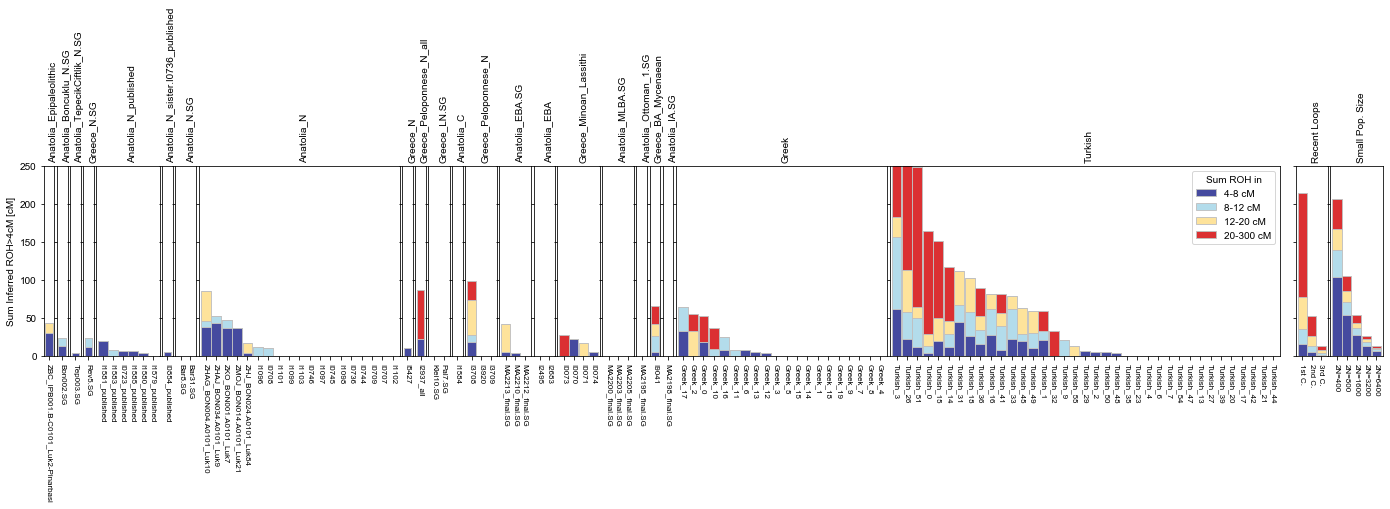

In [4]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1[df1["region"]=="Aegan"]
df1["clst"]=df1["pop"]
plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1) #./figures/aegan_pilot.pdf

In [ ]:
df1.sort_values(by="age", ascending=False)

### Levant

Saved figure to ./figures/levante.pdf


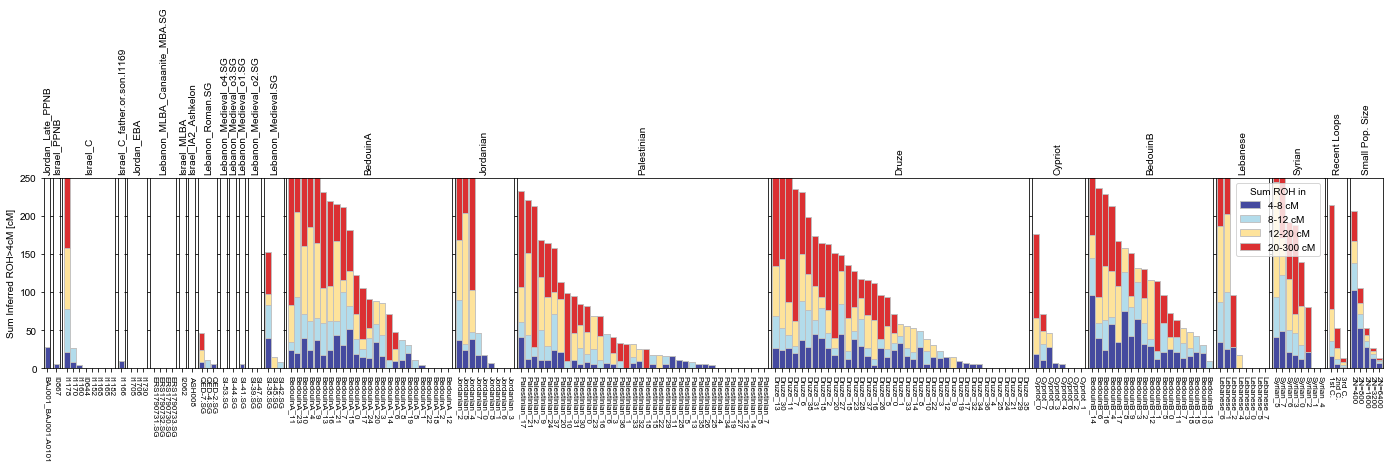

In [37]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1[df1["region"]=="Levante"]
df1["clst"]=df1["pop"]
plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])
plot_panel_row(plot_dfs1, savepath="./figures/levante.pdf", leg_pos=-1)

### Balkans

Saved figure to ./figures_test/balkans.pdf


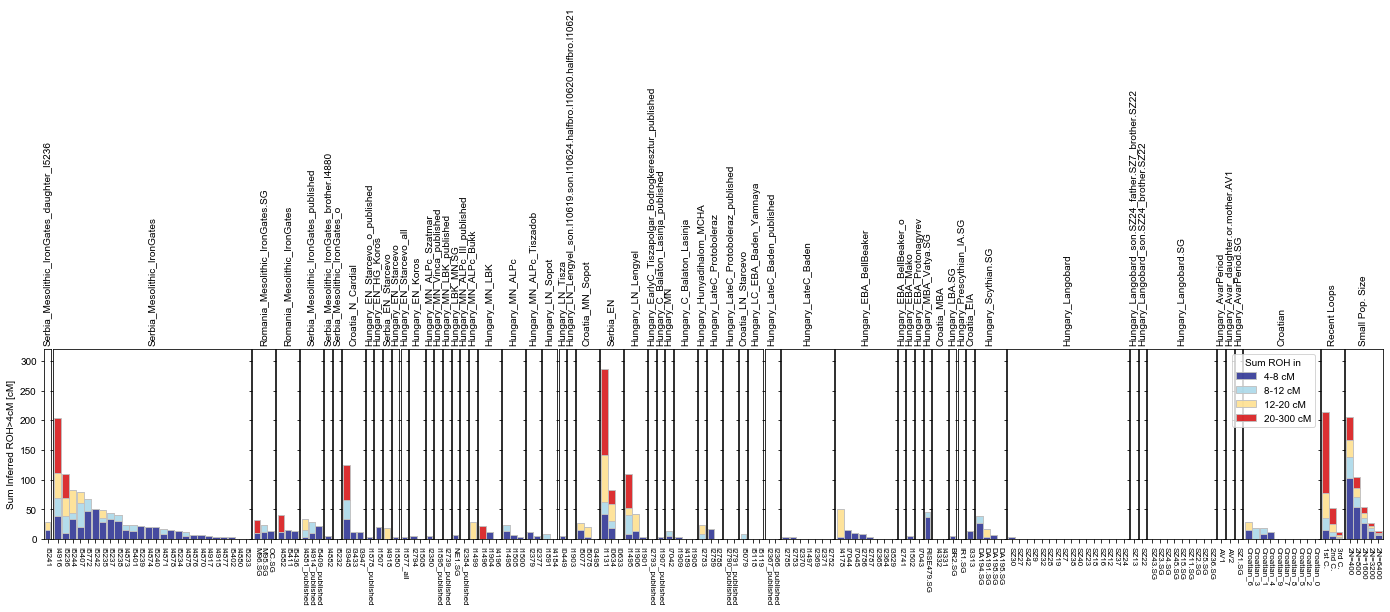

In [28]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1[df1["region"]=="Balkans"]
df1["clst"]=df1["pop"]
plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4,8,12,20])
plot_panel_row(plot_dfs1, savepath="./figures_test/balkans.pdf", leg_pos=-1, ylim=[0, 320])

### India/Pakistan/Turkmenistan

3732


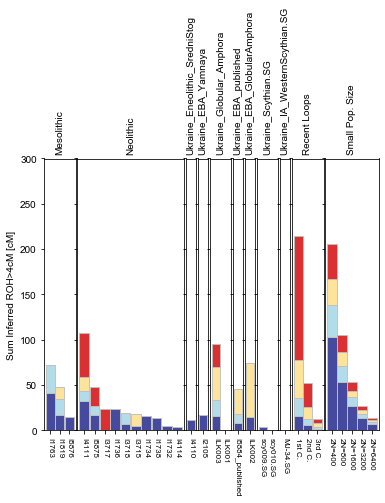

In [20]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
print(len(df1))
df1 = df1[df1["pop"].str.contains("Ukraine")][:]
plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])
plot_panel_row(plot_dfs1, savepath="", leg_pos=-11, ylim=[0, 300], 
               figsize=((len(df1)+8)/5, 5))

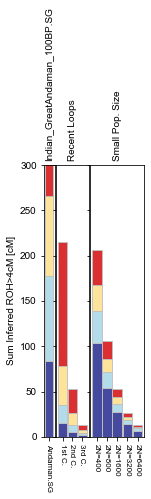

In [14]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1[df1["pop"].str.contains("Andaman")]
plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])
plot_panel_row(plot_dfs1, savepath="", leg_pos=-11, ylim=[0, 300], 
               figsize=((len(df1)+8)/5, 5))

3732


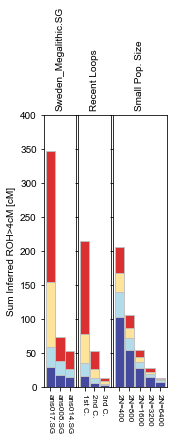

In [10]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
print(len(df1))
df1 = df1[df1["iid"].str.contains("ans0")]
plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])
plot_panel_row(plot_dfs1, savepath="", leg_pos=-11, ylim=[0, 400], 
               figsize=((len(df1)+8)/5, 5))

8


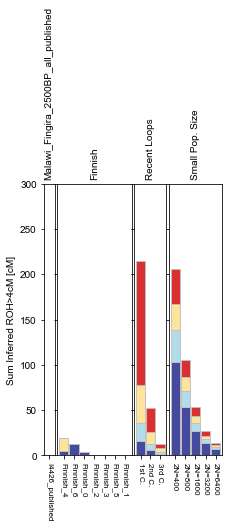

In [44]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1[df1["pop"].str.contains("Fin")]
print(len(df1))
plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])
plot_panel_row(plot_dfs1, savepath="", leg_pos=-11, ylim=[0, 300], 
               figsize=((len(df1)+8)/5, 5))

3732
Saved figure to ./figures_test/islands_roh.pdf


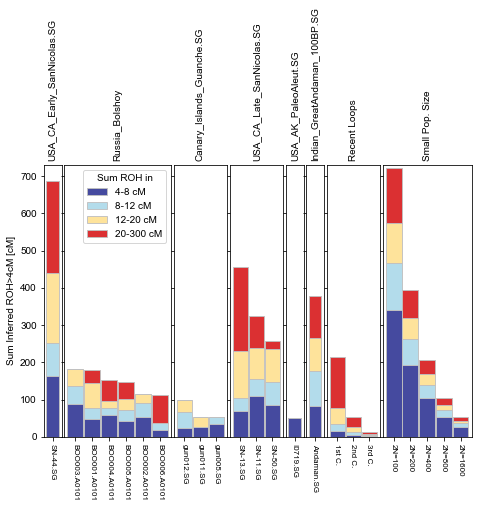

In [43]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
print(len(df1))
#df1 = df1[df1["study"].str.contains("MittnikNatureCommunications2018")]
#df1 = df1[df1["study"].str.contains("Lamnidis")]
df1 = df1[df1["pop"].str.contains("Nicolas|Bolshoy|Guanche|GreatAndaman|PaleoAleut")]
#df1["clst"]=df1["pop"]

plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])

plot_panel_row(plot_dfs1, savepath="./figures_test/islands_roh.pdf", leg_pos=-5, ylim=[0, 730], 
               figsize=((len(df1)+8)/3, 5), 
               Ns=[100, 200, 400, 800, 1600],
               )

In [ ]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1.sort_values(by="sum_roh>20", ascending=False)

In [ ]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
print(len(df1))
df1 = df1[df1["study"].str.contains("MittnikNatureCommunications2018")]
#df1 = df1[df1["study"].str.contains("Saag")]
df1["clst"]=df1["pop"]

df1

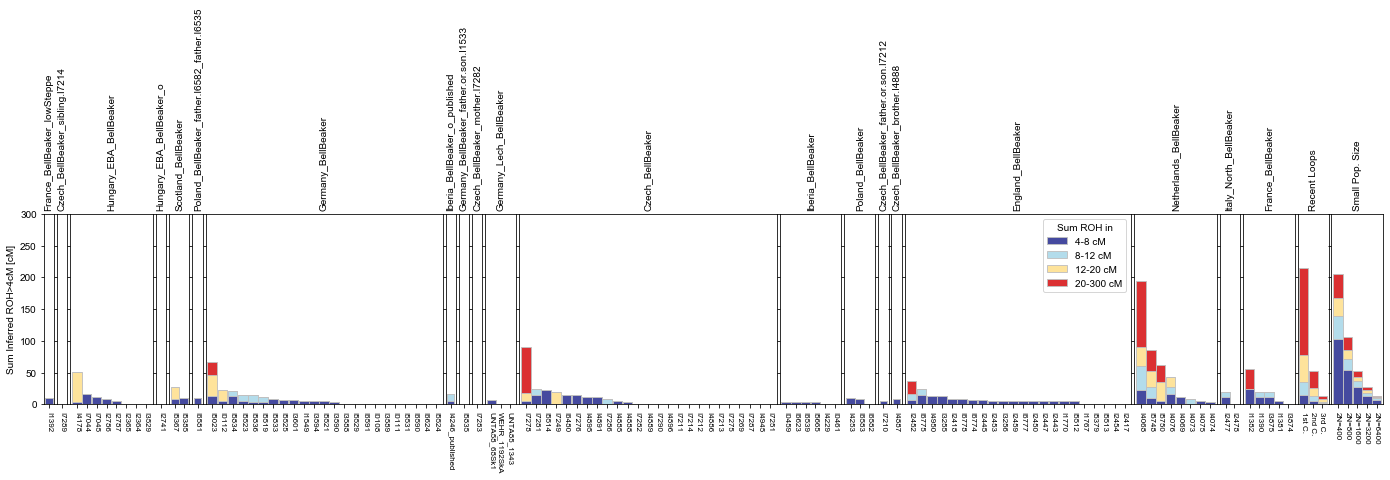

In [13]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1[df1["pop"].str.contains("Beaker")]
plot_dfs1, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])
plot_panel_row(plot_dfs1, savepath="", leg_pos=-4, ylim=[0, 300])

## Plot Lazardis Data (11 Individuals)

In [ ]:
df1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/lazaridis11_combined_roh05.csv", sep='\t')
plot_dfs, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])

plot_panel_row(plot_dfs, savepath="./figures_test/lazaridis16_bars.pdf", c=c,
               wspace=0.1, r_title=25, leg_pos=-2, ylim=[0,250], figsize=(9,3.5))

# Human Origins Dataset

### Plot and save every Population

In [ ]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["age"]==0]  # Extract the modern samples
df1["pop"].value_counts()
pops = set(df1["pop"])

for pop in pops:
    df_t = df1[df1["pop"]==pop].copy()    # Sindhi/Saudi/Makrani/Nganasan/Mozabite
    print(f"Doing Population {pop}: {len(df_t)} Individuals")
    savepath = "./figures/ho_pops_barplots/" + str(pop) + ".pdf" 
    plot_dfs1, cols = prepare_dfs_plot(df_t, cms=[4,8,12])
    plot_panel_row(plot_dfs1, savepath=savepath, leg_pos=-1, ylim=[0,250], 
                   r_title=0, show=False)

### Do them with 4 Length Bins
An additional 20 cM Bin

In [ ]:
df1 = pd.read_csv("./Empirical/HO/CombinedROH/combined_roh05.csv", sep='\t')
#df1 = df1[df1["age"]==0]  # Extract the modern samples
df1["pop"].value_counts()
pops = list(set(df1["pop"]))

for pop in pops[:]:
    df_t = df1[df1["pop"]==pop].copy()    # Sindhi/Saudi/Makrani/Nganasan/Mozabite
    print(f"Doing Population {pop}: {len(df_t)} Individuals")
    savepath = "./figures/ho_pops_barplots/" + str(pop) + ".pdf" 
    plot_dfs1, cols = prepare_dfs_plot(df_t, cms=[4,8,12,20])
    plot_panel_row(plot_dfs1, figsize=((len(plot_dfs1[0])+8)/3, 3.5),
                   savepath=savepath, leg_pos=-1, ylim=[0,250], 
                   r_title=0, show=False, c=c)
    plt.close() # Close all open figures, otherwise PICTOCALYPE
print("Finished!")

# Combine some interesting Pop Rows [Paper]
Strategy: Combine Single Pieces

### Do the Ancient South Americans (+ legend)

### Do key modern Populations (French, Han, Palestinian, Pathan)

Saved figure to ./figures/manuscript/barplots/big_pop.pdf


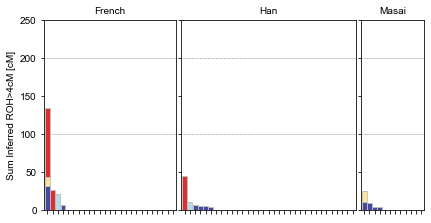

In [2]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
mod_clsts = ["French", "Han", "Masai"]

df_plots, lgths = prep_dfs_plot_exact(df1, pops=mod_clsts, mod_only=True)

plot_panel_row(df_plots, figsize=(np.sum(lgths)/10, 3.5), ylim=[0,250],
               ha_title="center", r_title=0, title_col="pop", hlines=[100, 200], 
               x_labels=False, leg_pos=0, degrees=[], Ns=[], 
               savepath="./figures/manuscript/barplots/big_pop.pdf")

Saved figure to ./figures/manuscript/barplots/cousin_pop.pdf


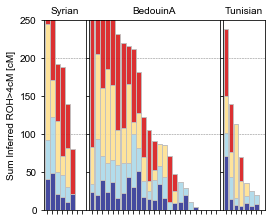

In [3]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
mod_clsts = ["Syrian", "BedouinA", "Tunisian"]

df_plots, lgths = prep_dfs_plot_exact(df1, pops=mod_clsts, mod_only=True)

plot_panel_row(df_plots, figsize=(np.sum(lgths)/10, 3.5), ylim=[0,250],
               ha_title="center", r_title=0, title_col="pop", hlines=[100, 200], 
               x_labels=False, leg_pos=0, degrees=[], Ns=[], 
               savepath="./figures/manuscript/barplots/cousin_pop.pdf")

Saved figure to ./figures/manuscript/barplots/small_pops.pdf


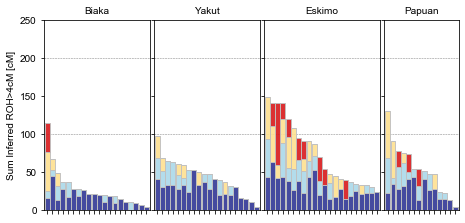

In [4]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1.sort_values(by="sum_roh>4", ascending=False)
mod_clsts = ["Biaka", "Yakut", "Eskimo", "Papuan"]

df_plots, lgths = prep_dfs_plot_exact(df1, pops=mod_clsts, mod_only=True)

plot_panel_row(df_plots, figsize=(np.sum(lgths)/10, 3.5), ylim=[0,250],
               ha_title="center", r_title=0, title_col="pop", hlines=[100, 200], 
               x_labels=False, leg_pos=0, degrees=[], Ns=[], 
               savepath="./figures/manuscript/barplots/small_pops.pdf")

# Paper: Plot Key Ancient Populations
Imperial Rome, Mesolithic Steppe, Anatolia N, Iberia Mesolithic, EN, N

# Plot Hunter Gatherer Populations

In [37]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df_t = df1[df1["economy"].values == "Hunter Gatherer"]

Saved figure to ./figures/manuscript/barplots/hg_pops.pdf


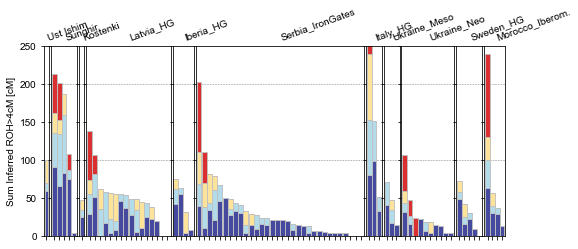

In [44]:
clsts = ["Ust_Ishim",  "Sunghir", "Kostenki", 
         "Latvia_HG", "Iberia_HG", "Serbia_Mesolithic_IronGates", "Italy_Mesolithic", "Ukraine_Mesolithic", 
         "Ukraine_N", "Sweden_HG_Motala", "Morocco_Iberomaurusian"]

labels = ["Ust Ishim", "Sunghir", "Kostenki", "Latvia_HG", "Iberia_HG", 
          "Serbia_IronGates", "Italy_HG", "Ukraine_Meso", 
          "Ukraine_Neo", "Sweden_HG", "Morocco_Iberom."]

df_plots, lgths = prep_dfs_plot_exact(df_t, pops=clsts, mod_only=False, exact=False)

plot_panel_row(df_plots, figsize=(np.sum(lgths)/10, 3.5), ylim=[0,250], fs_x=6,
               titles=labels, ha_title="left", r_title=20, title_col="pop", hlines=[100, 200], 
               x_labels=False, leg_pos=0, degrees=[], Ns=[],
               savepath="./figures/manuscript/barplots/hg_pops.pdf")

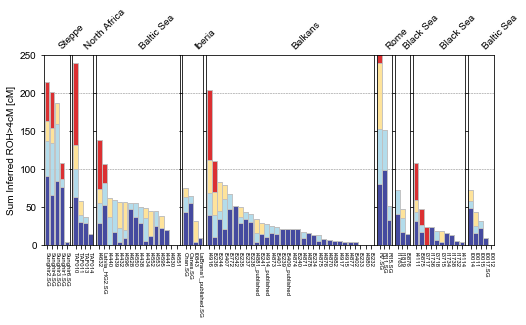

In [12]:
# Hunter Gatherers [not main plot]
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
regions = ["Central Europe", "Balkans", "Iberia", "Black Sea", "Baltic Sea", "Steppe", "Aegan"]
df_plot = df1[(df1["region"].isin(regions)) & (df1["economy"]=="Hunter Gatherer")].copy() # Also select only moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region", mod_group="pop")
plot_panel_row(df_plots, figsize=(np.sum(lgths)/10, 3.5), ylim=[0,250], fs_x=6,
               ha_title="left", r_title=45, title_col="region", hlines=[100, 200], 
               x_labels=True, leg_pos=0, degrees=[], Ns=[],
               savepath="")

# Plot Farmer Populations

In [7]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df_t= df1[df1["economy"]=="Agricultural"]
#df_t[df_t["clst"].str.contains("Sar")]["clst"].value_counts()
#df_t["pop"].value_counts()
#df_t[df_t["clst"].str.contains("Rom")]

In [12]:
df_ana = df_t[df_t["pop"].str.contains("Israel_C")]
idx= df_ana["sum_roh>4"]==0
print(f"{np.sum(idx)} / {len(idx)} Individuals have no ROH")
#np.sum(idx)
#len(idx)

5 / 9 Individuals have no ROH


In [11]:
df_ana.sort_values(by="age")

,iid,pop,max_roh,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,sum_roh>20,...,lon,age,study,clst,mean_cov,n_cov_snp,include_alt,region,color,economy
1050,I1178,Israel_C,91.121798,703.154187,30,682.380788,26,625.10111,20,545.019401,...,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C,2.383,719331,1,Levante,blue,Agricultural
1371,I0644,Israel_C,0.000000,0.000000,0,0.000000,0,0.00000,0,0.000000,...,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C,0.869,598616,1,Levante,blue,Agricultural
1375,I1160,Israel_C,4.081202,4.081202,1,0.000000,0,0.00000,0,0.000000,...,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C,1.308,597303,1,Levante,blue,Agricultural
1386,I1152,Israel_C,0.000000,0.000000,0,0.000000,0,0.00000,0,0.000000,...,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C,1.058,592889,1,Levante,blue,Agricultural
3407,I1168,Israel_C,0.000000,0.000000,0,0.000000,0,0.00000,0,0.000000,...,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C,0.985,544900,1,Levante,blue,Agricultural
3450,I1166,Israel_C_father.or.son.I1169,4.879100,9.593799,2,0.000000,0,0.00000,0,0.000000,...,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C_father.or.son.I1169,0.981,531821,1,Levante,blue,Agricultural
3596,I1170,Israel_C,9.192801,26.831901,4,18.287802,2,0.00000,0,0.000000,...,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C,0.620,467224,1,Levante,blue,Agricultural
3617,I1165,Israel_C,0.000000,0.000000,0,0.000000,0,0.00000,0,0.000000,...,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C,0.902,452444,1,Levante,blue,Agricultural
3677,I1182,Israel_C,0.000000,0.000000,0,0.000000,0,0.00000,0,0.000000,...,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C,0.584,421398,1,Levante,blue,Agricultural


Saved figure to ./figures/manuscript/barplots/farmer_pops.pdf


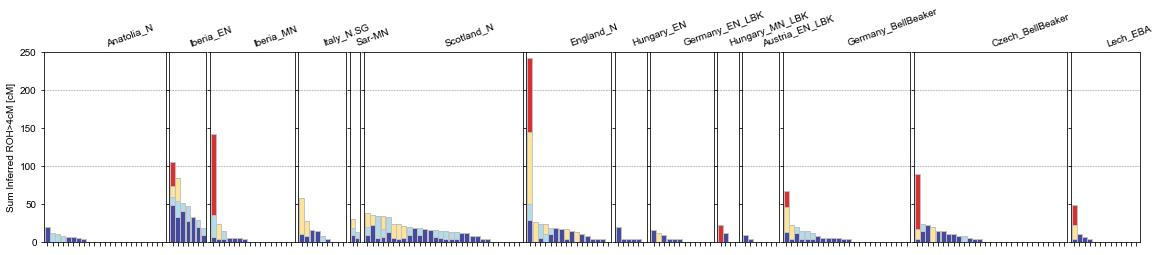

In [48]:
clsts = ["Anatolia_N", "Iberia_EN", "Iberia_MN", "Italy_N.SG", "Sar-MN", "Scotland_N", 
         "England_N", "Hungary_EN",
         "Germany_EN_LBK", "Hungary_MN_LBK", "Austria_EN_LBK", 
         "Germany_BellBeaker", "Czech_BellBeaker", "Lech_EBA"]
df_plots, lgths = prep_dfs_plot_exact(df_t, pops=clsts, mod_only=False, exact=False)

plot_panel_row(df_plots, figsize=(np.sum(lgths)/10, 3.5), ylim=[0,250], fs_x=6,
               ha_title="left", r_title=20, title_col="pop", hlines=[100, 200], 
               titles=clsts, x_labels=False, leg_pos=0, degrees=[], Ns=[],
               savepath="./figures/manuscript/barplots/farmer_pops.pdf")

# Plot the best Steppe has to offer

In [49]:
df_t= df1[df1["economy"]=="Pastoralist"]

Saved figure to ./figures/manuscript/barplots/pastoralist_pops.pdf


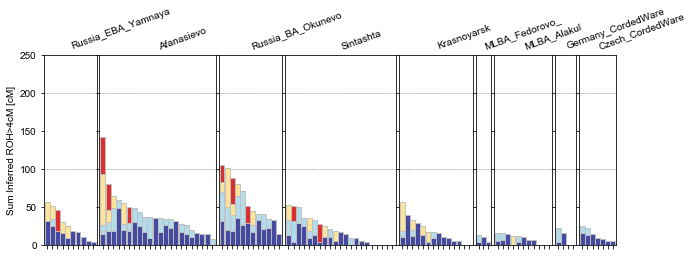

In [50]:
clsts = ["Russia_EBA_Yamnaya", "Afanasievo", "Russia_BA_Okunevo", "Sintashta", 
         "Krasnoyarsk",  "MLBA_Fedorovo_", "MLBA_Alakul", 
         "Germany_CordedWare", "Czech_CordedWare"]
df_plots, lgths = prep_dfs_plot_exact(df_t, pops=clsts, mod_only=False, exact=False)

plot_panel_row(df_plots, figsize=(np.sum(lgths)/10, 3.5), ylim=[0,250], fs_x=6,
               titles=clsts, ha_title="left", r_title=20, title_col="pop", hlines=[100, 200], 
               x_labels=False, leg_pos=0, degrees=[], Ns=[],
               savepath="./figures/manuscript/barplots/pastoralist_pops.pdf")

# Plot island populations

Saved figure to ./figures/manuscript/barplots/islands.pdf


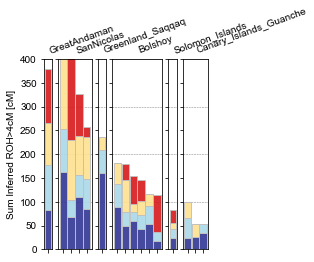

In [76]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
clsts = ["GreatAndaman", "SanNicolas", "Greenland_Saqqaq", "Bolshoy",  
         "Solomon_Islands", "Canary_Islands_Guanche"] # Paleo_ALeut

df_plots, lgths = prep_dfs_plot_exact(df1, pops=clsts, mod_only=False, exact=False)

plot_panel_row(df_plots, figsize=(np.sum(lgths)/5, 3.5), ylim=[0,400], fs_x=6, wspace=0.3,
               titles=clsts, ha_title="left", r_title=20, 
               title_col="pop", hlines=[100,200,300,400], 
               x_labels=False, leg_pos=0, degrees=[], Ns=[],
               savepath="./figures/manuscript/barplots/islands.pdf")

## Plot Americas

In [67]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = df1.sort_values(by="sum_roh>4", ascending=False)

In [70]:
df_patagonia = df1[df1["region"].str.contains("Patagonia") & df1["age"]>0]
df_andean = df1[df1["region"].str.contains("Andea") & df1["age"]>0]
df_pw = df1[df1["region"].str.contains("Pacific") & (~df1["clst"].str.contains("SanNicolas")) & (df1["age"]>0)]
df_at = df1[df1["region"].str.contains("Atlantic Coast") & df1["age"]>0]

df_plots = [df_patagonia, df_andean, df_pw, df_at]
labels = ["Patagonia", "Andean", "Pacific NW", "Atlantic Coast"]
lgths = [len(df) for df in df_plots]

Saved figure to ./figures/manuscript/barplots/sa.pdf


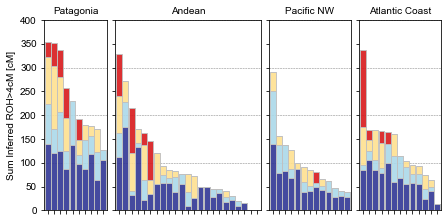

In [60]:
plot_panel_row(df_plots, figsize=(np.sum(lgths)/8, 3.5), ylim=[0,400], fs_x=6, wspace=0.1,
               titles=labels, ha_title="center", r_title=0, 
               title_col="pop", hlines=[100,200,300,400], 
               x_labels=False, leg_pos=0, degrees=[], 
               Ns=[], savepath="./figures/manuscript/barplots/sa.pdf")

# Do Pakistan Populations

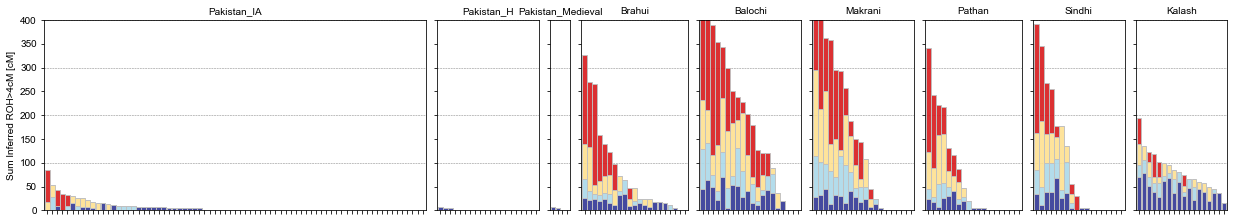

In [89]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
clsts = ["Pakistan_IA", "Pakistan_H", "Pakistan_Medieval", "Brahui", "Balochi", "Makrani", "Pathan", "Sindhi", "Kalash"]

df_plots, lgths = prep_dfs_plot_exact(df1, pops=clsts, mod_only=False, exact=False)

plot_panel_row(df_plots, figsize=(np.sum(lgths)/10, 3.5), 
               ylim=[0,400], fs_x=6, wspace=0.1,
               titles=clsts, ha_title="center", r_title=0, 
               title_col="pop", hlines=[100,200,300,400], 
               x_labels=False, leg_pos=0, degrees=[], Ns=[],
               savepath="")   # ./figures/manuscript/barplots/pakistan.pdf

# Do Levant

In [5]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')

Saved figure to ./figures/manuscript/barplots/levant.png


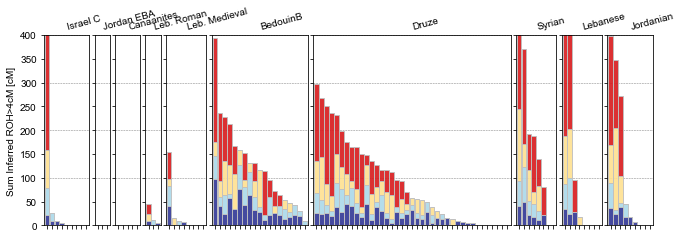

In [28]:
clsts = ["Israel_C", "Jordan_EBA", "Canaanite|Israel_MLBA", "Lebanon_Roman", "Lebanon_Medieval", "BedouinB", "Druze", "Syrian", "Lebanese", "Jordanian"]
labels = ["Israel C", "Jordan EBA", "Canaanites", "Leb. Roman", "Leb. Medieval", "BedouinB", "Druze", "Syrian", "Lebanese", "Jordanian"]
df_plots, lgths = prep_dfs_plot_exact(df1, pops=clsts, mod_only=False, exact=False)

plot_panel_row(df_plots, figsize=(np.sum(lgths)/10, 3.5), 
               ylim=[0,400], fs_x=6, wspace=0.1,
               titles=labels, ha_title="left", r_title=15, 
               title_col="pop", hlines=[100,200,300,400], 
               x_labels=False, leg_pos=0, degrees=[], Ns=[],
               savepath="./figures/manuscript/barplots/levant.png")   # ./figures/manuscript/barplots/levant.png

In [103]:
np.sum(df_pak["sum_roh>20"]>50)

33

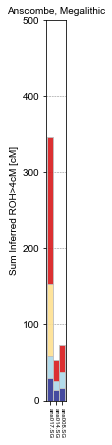

In [109]:
plot_panel_row(df_plots, figsize=(np.sum(lgths)/8, 7), ylim=[0,500], fs_x=6, wspace=0.1,
               titles=labels, ha_title="center", r_title=0, hspace_leg=0,
               title_col="pop", hlines=[100,200,300,400], 
               x_labels=True, leg_pos=0, degrees=[], 
               Ns=[], savepath="")

### Combine barplots panel plots into one folder

In [66]:
dir_tozip = "./figures/manuscript/barplots/"
dir_zip = "./figures/manuscript/barplots/bars.zip"
!zip -r -j $dir_zip $dir_tozip

updating: cousin_pop.pdf (deflated 25%)
updating: farmer_pops.pdf (deflated 20%)
updating: bar_legend.pdf (deflated 29%)
updating: hg_pops.pdf (deflated 22%)
updating: pastoralist_pops.pdf (deflated 22%)
updating: big_pop.pdf (deflated 27%)
updating: small_pops.pdf (deflated 23%)
updating: sa.pdf (deflated 24%)
updating: islands.pdf (deflated 27%)
updating: pakistan-checkpoint.png (deflated 16%)
updating: pakistan.png (deflated 16%)
updating: pakistan.pdf (deflated 19%)


In [ ]:
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df["sum_roh_4-8"]=df["sum_roh>4"]-df["sum_roh>8"]
df.sort_values(by="sum_roh_4-8", ascending=False)[:50]#["sum_roh_4-8"][:50]

In [54]:
#plot_panel_roh_bars([plot_dfs1, plot_dfs], ylim=[0,600], r_title=0, hspace=0.5)

## Calculate some Expectations

In [12]:
%%time
bins = [[0.04, 0.08], [0.08, 0.12], [0.12, 0.2], [0.2,3.0]] # 4 bis
#bins = [[0.20,200]]
c=["#313695", "#abd9e9", "#fee090", "#d7191c"] # Colors for 4 bins
Ns=[500, 1400, 10000]
degrees=[1, 2, 3, 4]

### Calcualte Expectations Cousins:
c_roh = create_cousins_roh(degrees = degrees, bins = bins)

### Calculate Expectations Ne:
n_roh = create_Ne_roh(Ns=Ns, bins = bins) # Legacy so that code below works
#std_roh = std_Ne_roh(Ns=Ns, bins = bins)

print(c_roh)
print(n_roh)
#print(std_roh)
#print(std_roh**2)

[[0.15417107 0.1989896  0.42775709 1.36425226]
 [0.0579345  0.06908513 0.13176871 0.26794258]
 [0.01947492 0.02146337 0.03640229 0.05146604]
 [0.0060908  0.00620523 0.00937594 0.00972349]]
[[0.83738322 0.28607663 0.23142621 0.30748262]
 [0.30979281 0.10418639 0.08368305 0.11036552]
 [0.04411506 0.01472364 0.01178546 0.01548821]]
CPU times: user 388 ms, sys: 17 µs, total: 388 ms
Wall time: 386 ms


# Plot missing coordinates

In [41]:
#df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df1 = pd.read_csv("./Data/ReichLabEigenstrat/Raw/meta.v42.csv", sep=",")
df_bad = df1[df1["lat"].isnull()]
df_counts = pd.DataFrame(df_bad["study"].value_counts())

In [29]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')

In [ ]:
df1[df1["clst"].str.contains("Aleut")]

# Legacy

In [3]:
def plot_bar_ax(ax, fracs, bins=[], c=["#313695", "#abd9e9", "#fee090", "#d7191c"], x_ticks = [], 
                ec = "silver", fs_l=10, fs = 10, fs_x=8, barWidth=0.95, ylim = [0,220], stds = [], title="", 
                yticks=False, legend=False, r_title=0, hlines=[], ylabel="Sum Inferred ROH>4cM [cM]"):
    """Plot bars of ROH on Axis.
    ax: Where to Plot on
    fracs: Fractions of Expected ROH: [n Inds, n Bins]
    c: Which colors to plot
    bins: List of Bins (needed for legend - plotted if len()>0)
    yticks: Whether to plot Y tick Labels
    legend: Whether to plot Legend
    fs_x: Fontsize on the x Labels
    r_title: Rotation of the title
    hlines: List where to plot hlines"""
    y = fracs ### Fractions (along 1st axis length classes)
    x = np.arange(len(y))

    for i in range(len(y[0,:])): # From last to first (For Legend)
        b = np.sum(y[:,:i], axis=1)
        ax.bar(x, y[:,i], bottom=b, color=c[i], edgecolor=ec, width=barWidth, label=f"{bins[i,0]}-{bins[i,1]} cM", alpha=0.9)
        if len(stds)>0 and i>0: # Plot some standard deviations.
            ax1.errorbar(r, b, yerr=stds[:,i], fmt='none', linewidth=2, color="k")
    
    if len(hlines)>0:
        for y in hlines:
            ax.axhline(y=y, zorder=0, linestyle="--", color="gray", lw=0.5)     
    
    if legend:
        ax.legend(fontsize=fs_l, loc="upper right", title="Sum ROH in")
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.set_ylim(ylim)
    ax.set_xlim(x[0] - 0.7*barWidth, x[-1] + 0.7*barWidth)
    if len(x_ticks)>0:
        ax.set_xticks(x)
        ax.set_xticklabels(x_ticks, fontsize=fs_x, rotation=270)
    else:
        ax.set_xticks([])
    if not yticks:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    if len(title)>0:
        ax.set_title(title, fontsize=fs, rotation=r_title)
        
        
def plot_panel_row(plot_dfs, wspace=0.05, hspace=0.01, figsize=(24,3.5), savepath="", x_ticks=True,
                   c=["#313695", "#abd9e9", "#fee090", "#d7191c"], ylim = [0,250], r_title = 90, 
                   leg_pos = -2, show=True, title_col="clst", legends=True, hlines=[],
                   bins = [[0.04, 0.08], [0.08, 0.12], [0.12, 0.2], [0.2, 3.0]],
                   degrees=[1, 2, 3], Ns=[400, 800, 1600, 3200, 6400]):
    """Plot row of ROH bin plots from plot_dfs (each df one panel)
    leg_pos = Where to plot legend (if outside range no legend plot)
    r_title: How much to rotate the title
    gs: Gridspec: If given plot on there.
    legends: Whether to plot the two legends
    hlines: Where to plot horizontal lines
    bins: list of length bins to plot [[a1,a2],...[z1,z2]]
    Ns: What population sizes to plot in barplot [list]
    degrees: What degrees of Cousins to plot. [list]"""
    bins_cM=(np.array(bins)*100).astype("int")
    n_plots = len(plot_dfs)
    width_ratios = [len(df) for df in plot_dfs]
    if legends:     
        n_plots+= 2
        width_ratios+=[len(degrees), len(Ns)]
        
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, n_plots, width_ratios=width_ratios, figure=fig)
    
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    for i,df in enumerate(plot_dfs):   
        if i==0:
            ytick=True
        else:
            ytick=False

        if i == (len(plot_dfs) + leg_pos):
            legend=True
        else:
            legend=False

        ax = plt.subplot(gs[i])    # Extract the Sub Plot to Plot onto
        obs_roh = df[cols].values
        
        ### Calculate the value in the Bins
        for i in range(len(cols)-1):
            obs_roh[:,i] = obs_roh[:,i] - obs_roh[:,i+1]
        
        if x_ticks:
            x_ticks0 = df["iid"].values
        else: 
            x_ticks0 = []
        plot_bar_ax(ax, obs_roh, bins_cM, yticks=ytick, legend=legend, r_title=r_title, c=c,
                    x_ticks = x_ticks0, title=df[title_col].values[0], ylim=ylim, hlines=hlines)

    #### Plot the legend bars
    if legends:
        ### 0) Calculate Expectations
        c_roh = create_cousins_roh(degrees = degrees, bins = bins)
        sum_roh = create_Ne_roh(Ns=Ns, bins = bins)
        
        ### 1) Small Pops
        ax = plt.subplot(gs[-2])    # The left subplot (Timeline)
        plot_bar_ax(ax, c_roh*100, bins_cM, yticks=False, legend=False, ylim=ylim, c=c, hlines=hlines,
                   x_ticks = ["1st C.", "2nd C.", "3rd C."], title="Recent Loops", r_title=r_title)
        ### 2) Cousins
        ax = plt.subplot(gs[-1])
        ticks_N = [f"2N={i}" for i in Ns]
        plot_bar_ax(ax, sum_roh*100, bins_cM, yticks=False, legend=False, ylim=ylim, c=c,
                    hlines=hlines, x_ticks = ticks_N, title="Small Pop. Size", r_title=r_title)

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}")
        
    if show:
        plt.show()
    return
    
    
def plot_legend_only(figsize=(7,6), wspace=0.05, hspace=0.01, savepath="",
                     fs=12, fs_l=10, fs_x=10, c=["#313695", "#abd9e9", "#fee090", "#d7191c"],
                     bins = [[0.04, 0.08], [0.08, 0.12], [0.12, 0.2], [0.2,3.0]],
                     degrees=[1, 2, 3], Ns=[400, 800, 1600, 3200, 6400],
                     ylim=[0,250]
                     ):
    """Plot Inbreeding from recent Cousins as well as small pop size.
    bins: list of length bins to plot [[a1,a2],...[z1,z2]]
    Ns: What population sizes to plot in barplot [list]
    degrees: What degrees of Cousins to plot. [list]"""
    width_ratios = [len(degrees), len(Ns)]
    bins_cM=(np.array(bins)*100).astype("int")
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios, figure=fig)
    ax_cousin = plt.subplot(gs[0])    # The left subplot (Timeline)
    ax_Ne = plt.subplot(gs[1])
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    ### Calcualte Expectations Cousins:
    c_roh = create_cousins_roh(degrees = degrees, bins = bins)
    
    ### Calculate Expectations Ne:
    sum_roh = create_Ne_roh(Ns=Ns, bins = bins)
    
    plot_bar_ax(ax_cousin, c_roh*100, bins_cM, yticks=True, legend=False, 
                fs=fs, fs_l=fs_l, fs_x=fs_x, c=c, ylabel="Expected Sum ROH>4cM [cM]",
                x_ticks = ["1st C.", "2nd C.", "3rd C."], title="Recent Loops",
                 ylim=ylim)

    ticks_N = [f"2N={i}" for i in Ns]
    plot_bar_ax(ax_Ne, sum_roh*100, bins_cM, yticks=False, legend=True, c=c, 
                fs=fs, fs_l=fs_l, fs_x=fs_x, x_ticks = ticks_N, 
                title="Small Pop. Size", ylim=ylim)
            
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}") 
    plt.show()
    
    
def prepare_dfs_plot(df, cms=[4,8,12], col_group="clst", split_modern=True,
                     mod_group="pop", sortcol=0):
    """Prepare the Dataframe which to plot
    Return split up (and sorted) list of df, return list of column names
    df: Master Dataframe
    cms: Minimum Length of Chromosomes in bins
    sortcol: By which > column to sort within group [int]
    if split_modern, split age==0 samples by mod_group
    """
    
    if split_modern:
        mod_idx = df["age"]==0  # Pull out modern idx
        df.loc[mod_idx, col_group]=df.loc[mod_idx, mod_group]
        
    plot_dfs = [dft for _, dft in df.groupby(col_group)]
    ### Sort by age
    idx = np.argsort([-df["age"].values[0] for df in plot_dfs])
    plot_dfs = [plot_dfs[i] for i in idx] ## Sort
    
    ### Split up blocks and sort by lowest
    cols = [f"sum_roh>{cm}" for cm in cms]
    for df in plot_dfs:
        df.sort_values(by=cols[sortcol], inplace=True, ascending=False)
    return plot_dfs, cols

In [4]:
def create_cousins_roh(degrees=[1,2,3], 
                       bins=[[0.04,0.08],[0.08,0.12],[0.12,0.2],[0.2,3.0]], bin_n=10000):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for Cousins of degree degrees [list]
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    c_roh = np.zeros((len(degrees),len(bins))) # Container for results Cousins
    for i,c in enumerate(degrees):
        for j,b in enumerate(bins):
            m = c*2 + 4
            c_roh[i,j] = e_roh.exp_roh_len_in_bin_rel(l=b, m=m, comm_anc=4, bins=10000)
    return c_roh

#bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]  # The bins I want to plot (eventually maybe do 12,16 as welll)
#cousins = [1, 2, 3]  # Which Cousins to Plot

def create_Ne_roh(Ns=[400, 800, 1600, 3200, 6400], 
                  bins=[[0.04,0.08],[0.08,0.12],[0.12,0.2],[0.2,3.0]], bin_n=10000):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for panmictic population sizes
    Ns: List of population sizes
    bins: Length Bins (in Morgan) to calculate expectations from
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    n_roh = np.zeros((len(Ns),len(bins))) # Container for results Cousins
    for i,N in enumerate(Ns):
        for j,b in enumerate(bins):
            n_roh[i,j] = e_roh.exp_roh_len_in_bin_N(b, N=N, bins=bin_n)
    return n_roh

def std_Ne_roh(Ns=[400, 800, 1600, 3200, 6400], 
                  bins=[[0.04,0.08],[0.08,0.12],[0.12,0.2],[0.2,3.0]], bin_n=10000):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for panmictic population sizes
    Ns: List of population sizes
    bins: Length Bins (in Morgan) to calculate expectations from
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    var_roh = np.zeros((len(Ns),len(bins))) # Container for results Cousins
    for i,N in enumerate(Ns):
        for j,b in enumerate(bins):
            var_roh[i,j] = e_roh.var_roh_len_in_bin_N(b, N=N, bins=bin_n)
    return np.sqrt(var_roh)  # Return Standard Deviation

In [6]:
def plot_panel_2d(plot_dfs, gs=0):
    """Plot 2D Panel of Bar Plots for ROH"""
    raise NotImplementedError("pls do this")

def prep_gridspecs_2d(dim_list, fig, height_ratios=[]):
    """Prepare Gridspec objects.
    Return list of list of axis to plot on. 
    dim_list: List of Dimensions [integer list] for each row)
    fig: Figure Object on where to do it
    height_ratios: Ratios of the Heights of rows"""
    if len(height_ratios)==0:
        height_ratios = [1 for _ in dim_list]
        
    gs = gridspec.GridSpec(len(dim_list), 1, height_ratios=height_ratios, figure=fig)
    
    ax_list = []
    for i,d in enumerate(dim_list):
        gss = gs[i].subgridspec(1, len(d), width_ratios=d)   # Do the width_ratios here!!
        ax_list0 = [plt.subplot(g) for g in gss] # Create Axis Objects
        ax_list.append(ax_list0)
    return ax_list, gs

def plot_panel_roh_bars(plot_dfs, figsize=(24,6), wspace=2.0, hspace=2.0, 
                        ylim=[0,600], r_title=90, leg_pos=-1, bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]):
    """Plot a panel of ROH Bars.
    plot_all_dfs: List of dfs to plot"""
    fig = plt.figure(figsize=figsize)
    bins_cM=(np.array(bins)*100).astype("int")
    
    dim_list = [list(map(len,ls)) for ls in plot_dfs]
    ax_list, gs = prep_gridspecs_2d(dim_list, fig)

    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    for j, df_row in enumerate(plot_dfs): 
        for i, df in enumerate(df_row):   
            if i==0:
                ytick=True
            else:
                ytick=False

            if i == (len(df_row) + leg_pos):
                legend=True
            else:
                legend=False

            ax = ax_list[j][i]
            obs_roh = df[cols].values
            obs_roh[:,0] = obs_roh[:,0] - obs_roh[:,1]
            obs_roh[:,1] = obs_roh[:,1] - obs_roh[:,2]
            obs_roh[:,2] = obs_roh[:,2]

            plot_bar_ax(ax, obs_roh, bins_cM, yticks=ytick, legend=legend, r_title=r_title,
                        x_ticks = df["iid"].values, title=df["clst"].values[0], ylim=ylim)
    plt.show()

# Area 51

In [78]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')

In [82]:
df_anc = df1[df1["age"]>0]

In [83]:
np.sum(df_anc["sum_roh>20"]>=50)

59

In [86]:
df_inbreed = df_anc[df_anc["sum_roh>20"]>=50].reset_index()

In [ ]:
df_inbreed

In [ ]:
df_anc.sort_values(by="sum_roh>20", ascending=False)